# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_with_TI_ciclo1_multiclass_jupyter_aug_dim_53TIs.pkl')
print(df.shape)
df.head(2)

(139881, 71)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,...,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53462.598377,53394.139577,...,11,2,2,15.0,HOLD,2,1,1,0,0
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53446.732251,53397.932381,...,11,2,2,50.0,HOLD,2,1,1,0,0


## Split dos Dados

In [5]:
df.columns.tolist()
df.columns.array

<PandasArray>
[             'DATETIME',                  'DATE',                  'TIME',
                  'OPEN',                  'HIGH',                   'LOW',
                 'CLOSE',                   'VOL',           'EMA_5_CLOSE',
          'EMA_10_CLOSE',          'EMA_20_CLOSE',            'EMA_5_OPEN',
           'EMA_10_OPEN',           'EMA_20_OPEN',            'EMA_5_HIGH',
           'EMA_10_HIGH',           'EMA_20_HIGH',             'EMA_5_LOW',
            'EMA_10_LOW',            'EMA_20_LOW',                'KAMA_5',
               'KAMA_10',               'KAMA_20',            'MIDPOINT_3',
           'MIDPOINT_12',            'MIDPRICE_3',           'MIDPRICE_12',
               'TRIMA_5',              'TRIMA_10',              'TRIMA_20',
                 'ADX_3',                 'ADX_6',                'ADX_10',
                   'BOP',                 'MOM_3',                 'MOM_6',
                'MOM_10',                'MOM_14',                 'ROC_3'

In [6]:
print(df.shape)
df2 = df.drop([  'MES',
                 'DIA_SEMANA', 
                 'TARGET_WIN',   
                 'TARGET_WIN_CAT_ENC',
                 'HOLD',
                 'SELL',
                 'BUY'
            
              ], axis=1)
print(df2.shape)
df2.head(2)

(139881, 71)
(139881, 64)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53462.598377,53394.139577,...,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0,2,HOLD,2
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53446.732251,53397.932381,...,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0,2,HOLD,2


In [7]:
df3 = df2[df2['DATETIME'].dt.year < 2020]
df3.drop(['DATE', 'TIME'], axis=1, inplace=True)
df4 = df3[df3['DATETIME'].dt.year > 2014].reset_index(drop=True)
df4

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DATETIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,EMA_5_OPEN,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
0,2015-01-02 09:00:00,50200.0,50400.0,50165.0,50275.0,861.0,50325.205919,50381.098425,50504.834778,50310.326119,...,-1281.593817,-165899.0,118.566120,105.950934,106.052199,107.965299,235.0,0,HOLD,2
1,2015-01-02 09:05:00,50275.0,50370.0,50185.0,50335.0,968.0,50328.470612,50372.716893,50488.660037,50298.550746,...,-915.986039,-164931.0,140.710746,119.125779,112.631182,111.817034,185.0,0,HOLD,2
2,2015-01-02 09:10:00,50335.0,50340.0,50205.0,50285.0,825.0,50313.980408,50356.768367,50469.263843,50310.700497,...,-637.960745,-165756.0,138.807164,121.771482,114.495250,112.976182,135.0,0,HOLD,2
3,2015-01-02 09:15:00,50300.0,50315.0,50215.0,50280.0,406.0,50302.653605,50342.810482,50451.238715,50307.133665,...,-429.099218,-166162.0,125.871443,118.142902,113.287313,112.327373,100.0,0,SELL,1
4,2015-01-02 09:20:00,50265.0,50280.0,50175.0,50190.0,958.0,50265.102404,50315.026758,50426.358837,50293.089110,...,-544.595225,-167120.0,118.914295,115.952418,112.596703,111.961004,105.0,0,SELL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132938,2019-12-30 17:45:00,116245.0,116310.0,116155.0,116185.0,56195.0,116340.624588,116429.656185,116502.191830,116419.865436,...,-57793.952461,-7927844.0,179.921938,145.712683,126.369144,125.228206,155.0,2,SELL,1
132939,2019-12-30 17:50:00,116185.0,116265.0,116060.0,116105.0,60633.0,116262.083059,116370.627788,116464.364037,116341.576958,...,-72510.139626,-7988477.0,188.281292,155.593903,132.921715,129.216796,205.0,2,SELL,1
132940,2019-12-30 17:55:00,116105.0,116140.0,115875.0,115975.0,72789.0,116166.388706,116298.695463,116417.757938,116262.717972,...,-79338.713875,-8061266.0,213.854195,173.828252,143.928239,136.005956,265.0,2,BUY,0
132941,2019-12-30 18:00:00,115985.0,116020.0,115850.0,115925.0,43625.0,116085.925804,116230.750833,116370.828611,116170.145315,...,-77901.331778,-8104891.0,199.236130,173.190210,146.100886,137.705658,170.0,2,BUY,0


In [8]:
df_train = df2[(df2['DATETIME'] >= '2015-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df2[(df2['DATETIME'] >= '2017-12-01') & (df2['DATETIME'] < '2019-07-01')]
#df_train = df_train.iloc[-10000:, :]

df_train = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-07-01')]

#----------------------------------------------------------------------------------------------------

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-03-01')]
#df_valid = df_valid.iloc[:6600, :]

df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-01-01')]

#----------------------------------------------------------------------------------------------------

df_test  = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2020-01-01')]
#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#df_test  = df2[(df2['DATETIME'] < '2017-12-01')]
#df_test = df_test.iloc[:500,:]

df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#----------------------------------------------------------------------------------------------------

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df2['DATETIME'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 28.3% | Validation: 9.7% | Test: 2.9%
(39552, 61) (13596, 61) (4064, 61)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
df_test.iloc[19:200].head(1)

,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,EMA_5_OPEN,EMA_10_OPEN,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
135836,117325.0,117425.0,117260.0,117400.0,87105.0,117228.122937,117137.461639,117010.529854,117142.182637,117084.640892,...,95344.558922,-7850190.0,212.171216,205.912372,197.823329,186.913789,165.0,1,HOLD,2


In [10]:
df_train['TARGET_WIN_CAT3'].value_counts()

HOLD    26622
BUY      6492
SELL     6438
Name: TARGET_WIN_CAT3, dtype: int64

In [11]:
df_train['TARGET_WIN_CAT3'].value_counts()[0]

26622

In [12]:
hold_train = df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[2]
hold_valid = df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[2]
hold_test = df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[2]

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_test))



Dados Categóricos de Treino -- BUY: 6492 | SELL: 6438 | HOLD: 26622

Dados Categóricos de Validação -- BUY: 1912 | SELL: 1784 | HOLD: 9900

Dados Categóricos de Teste -- BUY: 741 | SELL: 727 | HOLD: 2596


In [13]:
buy_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

buy_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

buy_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 2171 | SELL: 2166 | HOLD: 6613

Dados Categóricos de Validação Hora Nobre -- BUY: 724 | SELL: 702 | HOLD: 2354

Dados Categóricos de Teste Hora Nobre -- BUY: 250 | SELL: 242 | HOLD: 618


In [14]:
df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3'].value_counts()

HORA_NOBRE  TARGET_WIN_CAT3
0           HOLD                1506
            SELL                 351
            BUY                  328
1           HOLD                6613
            SELL                2171
            BUY                 2166
2           HOLD               18503
            BUY                 3998
            SELL                3916
Name: TARGET_WIN_CAT3, dtype: int64

In [15]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

6613
2171
4442


In [16]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

2354
719
1635


In [17]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

618
253
365


In [18]:
def normalize(data):

    scaler_x = StandardScaler()

    x = data.iloc[:, :-3]
    x = scaler_x.fit_transform(x) 

    y = data.iloc[:,-2]
    y_list = np.array(y.to_list())

    return x, y_list

In [19]:
def get_train_valid_test_data(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    for i in range(len(df) - seq_len):
        if df['TARGET_WIN_CAT3'][i+seq_len-1] == 'HOLD':
            if amostragem[a] == 0:
                df.drop((i+seq_len-1), axis=0, inplace=True) 
            a+=1

    x, y = normalize(df)

    return x, y

In [20]:
def next_window(i, seq_len, df):
    df = df[i:i+seq_len]
    scaler_x = StandardScaler()
    
    x = df.iloc[:, :-3]
    x = scaler_x.fit_transform(x) 
    
    y = df.iloc[-1,-2]
    # y_list = np.array(y.to_list())
    
    return x, y

In [21]:
def get_train_valid_test_data_Slide_Window(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    data_x = []
    data_y = []
    for i in range(len(df) - seq_len):
        if df['TARGET_WIN_CAT3'].iloc[i+seq_len-1] == 'HOLD':
            if amostragem[a] == 1:    
                x, y = next_window(i, seq_len, df)
                data_x.append(x)
                data_y.append(y)
            a+=1
        else:
            x, y = next_window(i, seq_len, df)
            data_x.append(x)
            data_y.append(y)

    return np.array(data_x), np.array(data_y)

In [22]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=1, 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)
print('x_train: ', x_train.shape,' | y_train: ', y_train.shape)

df.shape:  (10950, 61)
x_train:  (6509, 58)  | y_train:  (6509,)


In [23]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train_sw, y_train_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_train_reset_index, 
                                                                 amostragem=amostra_train)
print('x_train_sw: ', x_train_sw.shape,' | y_train_sw: ', y_train_sw.shape)

df.shape:  (10950, 61)
x_train_sw:  (6483, 50, 58)  | y_train_sw:  (6483,)


In [24]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

6509 6509
6483 6483


In [25]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data(seq_len=1, 
                                             df=df_valid_reset_index, 
                                             amostragem=amostra_valid)
print(x_valid.shape, y_valid.shape)

df.shape:  (3780, 61)
(2145, 58) (2145,)


In [26]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid_sw, y_valid_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_valid_reset_index, 
                                                                 amostragem=amostra_valid)
print(x_valid_sw.shape, y_valid_sw.shape)

df.shape:  (3780, 61)
(2120, 50, 58) (2120,)


In [27]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test, y_test = get_train_valid_test_data(seq_len=1, 
                                             df=df_test_reset_index, 
                                             amostragem=amostra_test)
print(x_test.shape, y_test.shape)

df.shape:  (1110, 61)
(745, 58) (745,)


In [28]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in y_test:
    if n == 'BUY':
        cont_buy+=1
    if n == 'HOLD':
        cont_hold+=1
    if n == 'SELL':
        cont_sell+=1

print('y_test.size: ', y_test.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

y_test.size:  745  | cont_buy:  250  | cont_hold:  253  | cont_sell:  242


In [29]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test_sw, y_test_sw = get_train_valid_test_data_Slide_Window(   seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_test_reset_index, 
                                                                 amostragem=amostra_test)
print(x_test_sw.shape, y_test_sw.shape)

df.shape:  (1110, 61)
(710, 50, 58) (710,)


In [30]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in y_test_sw:
    if n == 'BUY':
        cont_buy+=1
    if n == 'HOLD':
        cont_hold+=1
    if n == 'SELL':
        cont_sell+=1

print('y_test_sw.size: ', y_test_sw.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

y_test_sw.size:  710  | cont_buy:  227  | cont_hold:  244  | cont_sell:  239


In [31]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

6509 6509
6483 6483


## Cálculo do Weighted F Score

In [32]:
def weightedFScore(confusion_matrix):
    beta_1 = math.pow(0.5, 2)
    beta_2 = math.pow(0.25, 2)
    beta_3 = math.pow(0.125, 2)
    
    num_tu = confusion_matrix[[0],[0]]
    num_tf = confusion_matrix[[1],[1]]
    num_td = confusion_matrix[[2],[2]]
    
    wrongF_trueU = confusion_matrix[[0],[1]]
    wrongD_trueU = confusion_matrix[[0],[2]]
    
    wrongU_trueF = confusion_matrix[[1],[0]]
    wrongD_trueF = confusion_matrix[[1],[2]]
  
    wrongU_trueD = confusion_matrix[[2],[0]]
    wrongF_trueD = confusion_matrix[[2],[1]]
    
    num_tp = num_tu + num_td + (beta_3 * num_tf)
    erro_tipo_1 = wrongU_trueD + wrongD_trueU
    erro_tipo_2 = wrongU_trueF + wrongD_trueF
    erro_tipo_3 = wrongF_trueU + wrongF_trueD
    
    num = (1 + beta_1 + beta_2) * num_tp
    den = num + erro_tipo_1 + (beta_1 * erro_tipo_2) + (beta_2 * erro_tipo_3)
    
    wFScore = num / den
    
    return wFScore

# Modelos

In [33]:
import lightgbm as lgbm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## LightGBM

In [34]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=0, n_estimators=5000, learning_rate=0.001, num_leaves=2**6,
                                 subsample=0.9, subsample_freq=1, colsample_bytree=1.)

model_lgbm.fit(x_train, y_train)
predict_lgbm = model_lgbm.predict(x_test)

accuracy_score_LGBM = accuracy_score(y_test, predict_lgbm)

print('Accuracy Score - LightGBM: ', accuracy_score_LGBM)

Accuracy Score - LightGBM:  0.3651006711409396
              precision    recall  f1-score   support

         BUY       0.35      0.32      0.33       250
        HOLD       0.40      0.45      0.42       253
        SELL       0.34      0.32      0.33       242

    accuracy                           0.37       745
   macro avg       0.36      0.36      0.36       745
weighted avg       0.36      0.37      0.36       745



In [ ]:
print(classification_report(y_test, predict_lgbm))

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_lgbm, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[ 81,  93,  76],
       [ 64, 113,  76],
       [ 89,  75,  78]], dtype=int64)

In [37]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in predict_lgbm:
    if n == 'BUY':
        cont_buy+=1
    if n == 'SELL':
        cont_sell+=1
    if n == 'HOLD':
        cont_hold+=1

print('predict_lgbm.size: ', predict_lgbm.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

predict_lgbm.size:  745  | cont_buy:  234  | cont_hold:  281  | cont_sell:  230


<AxesSubplot:>

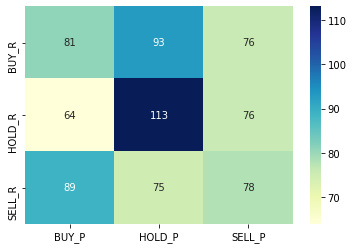

In [38]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LGBM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

In [39]:
weightedFScore_LGBM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LGBM

0.5005989050579096

### Compare train and test set accuracy

In [40]:
#y_pred_train = model_lgbm.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [41]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_lgbm.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_lgbm.score(x_test, y_test)))

In [42]:
#print('Validation set score: {:.4f}'.format(model_lgbm.score(x_valid, y_valid)))

## Random Forest

In [43]:
model_randomF = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=5000)
model_randomF.fit(x_train, y_train)
predict_randomF = model_randomF.predict(x_test)

accuracy_score_RF = accuracy_score(y_test, predict_randomF)
print('Accuracy Score - Random Forest: ', accuracy_score_RF)

Accuracy Score - Random Forest:  0.3731543624161074


In [44]:
print(classification_report(y_test, predict_randomF))

              precision    recall  f1-score   support

         BUY       0.37      0.36      0.37       250
        HOLD       0.39      0.40      0.39       253
        SELL       0.36      0.36      0.36       242

    accuracy                           0.37       745
   macro avg       0.37      0.37      0.37       745
weighted avg       0.37      0.37      0.37       745



In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_randomF, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[ 91,  81,  78],
       [ 75, 101,  77],
       [ 78,  78,  86]], dtype=int64)

In [46]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in predict_randomF:
    if n == 'BUY':
        cont_buy+=1
    if n == 'SELL':
        cont_sell+=1
    if n == 'HOLD':
        cont_hold+=1

print('predict_randomF.size: ', predict_randomF.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

predict_randomF.size:  745  | cont_buy:  244  | cont_hold:  260  | cont_sell:  241


<AxesSubplot:>

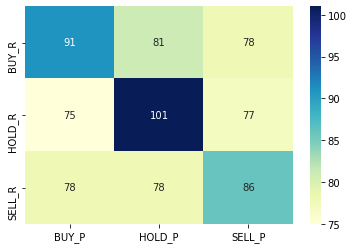

In [47]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_RF = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

In [48]:
weightedFScore_RF = weightedFScore(confusion_matrix)[0] 
weightedFScore_RF

0.5347305616019927

### Compare train and test set accuracy

In [49]:
#y_pred_train = model_randomF.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [50]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_randomF.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_randomF.score(x_test, y_test)))

In [51]:
#print('Validation set score: {:.4f}'.format(model_randomF.score(x_valid, y_valid)))

# Deep Learning

In [52]:
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_categ_data(data):
    labelencoder = LabelEncoder()
    x = labelencoder.fit_transform(data)
    data_encoded = to_categorical(x)
    
    #print(data[10:20])
    #print(data_encoded[10:20])
    
    return data_encoded

Using TensorFlow backend.


In [53]:
# example of training a final classification model
from keras.models import Sequential, load_model
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
dim = x_train.shape[1]

## DNN

In [54]:
# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(75, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(25, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[model] Model Compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               5900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
________________

In [55]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_DNN.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_enc = encode_categ_data(y_train)
y_valid_enc = encode_categ_data(y_valid)
H = model_dnn.fit( x_train, y_train_enc, validation_data=(x_valid, y_valid_enc), epochs=50, 
               callbacks=callbacks, workers=1 )

model_dnn.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started

Train on 6509 samples, validate on 2145 samples
Epoch 1/50
6509/6509 [==============================] - 6s 934us/step - loss: 1.1141 - accuracy: 0.3417 - val_loss: 1.0896 - val_accuracy: 0.3846
Epoch 2/50
6509/6509 [==============================] - 2s 286us/step - loss: 1.0981 - accuracy: 0.3632 - val_loss: 1.0832 - val_accuracy: 0.3944
Epoch 3/50
6509/6509 [==============================] - 2s 283us/step - loss: 1.0879 - accuracy: 0.3724 - val_loss: 1.0829 - val_accuracy: 0.3995
Epoch 4/50
6509/6509 [==============================] - 2s 286us/step - loss: 1.0865 - accuracy: 0.3799 - val_loss: 1.0813 - val_accuracy: 0.4009
Epoch 5/50
6509/6509 [==============================] - 2s 330us/step - loss: 1.0811 - accuracy: 0.3896 - val_loss: 1.0837 - val_accuracy: 0.3800
Epoch 6/50
6509/6509 [==============================] - 2s 328us/step - loss: 1.0853 - accuracy: 0.3910 - val_loss: 1.0803 - val_accuracy: 0.3944
Epoch 7/50
6509/6509 [============================

In [56]:
# new instances where we do not know the answer
y_pred = model_dnn.predict(x_test) 
y_pred

array([[0.31064868, 0.44750518, 0.24184608],
       [0.25892818, 0.6397037 , 0.10136806],
       [0.18100649, 0.774467  , 0.04452657],
       ...,
       [0.46935314, 0.286923  , 0.24372387],
       [0.47118816, 0.32731926, 0.2014926 ],
       [0.50453156, 0.27655986, 0.21890853]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


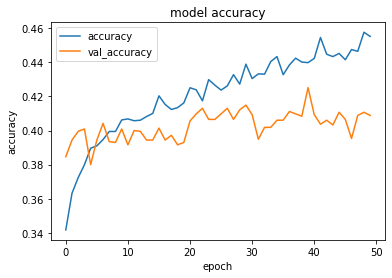

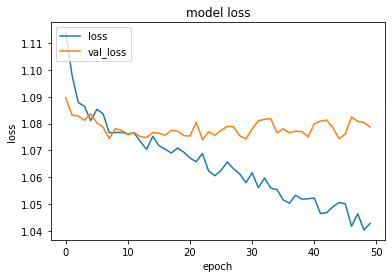

In [57]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [58]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_enc = encode_categ_data(y_test)
for i in y_test_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [59]:
print(y_pred[10:20])
print(y_test_enc[10:20])

[[0.3179941  0.403341   0.27866486]
 [0.3151805  0.40311125 0.28170824]
 [0.3099066  0.41813374 0.2719597 ]
 [0.24201362 0.6121408  0.14584553]
 [0.21035527 0.676917   0.11272772]
 [0.24548268 0.59184366 0.16267368]
 [0.26552457 0.5455339  0.18894154]
 [0.27970293 0.48188585 0.23841117]
 [0.2785201  0.46015212 0.26132783]
 [0.27880827 0.45609307 0.26509863]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [60]:
print(pred_array[10:20])
print(real_array[10:20])

[1 1 1 1 1 1 1 1 1 1]
[0 0 1 1 0 0 0 0 0 0]


In [61]:
accuracy_score_DNN = accuracy_score(real_array, pred_array)
print('Accuracy Score - DL: ', accuracy_score_DNN)

Accuracy Score - DL:  0.4


In [62]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.40      0.28      0.33       250
           1       0.41      0.47      0.44       253
           2       0.40      0.45      0.42       242

    accuracy                           0.40       745
   macro avg       0.40      0.40      0.39       745
weighted avg       0.40      0.40      0.39       745



In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[ 69,  96,  85],
       [ 51, 119,  83],
       [ 54,  78, 110]], dtype=int64)

In [64]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in real_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('real_array.size: ', real_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

real_array.size:  745  | cont_buy:  250  | cont_hold:  253  | cont_sell:  242


In [65]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in pred_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('pred_array.size: ', pred_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

pred_array.size:  745  | cont_buy:  174  | cont_hold:  293  | cont_sell:  278


<AxesSubplot:>

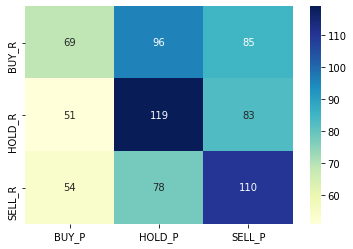

In [66]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_DNN = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [67]:
weightedFScore_DNN = weightedFScore(confusion_matrix)[0] 
weightedFScore_DNN

0.5641741576554308

In [68]:
y_pred_train = model_dnn.predict(x_train)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score: 0.4812


# LSTM

In [69]:
# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(200, input_shape=(timesteps, dim), return_sequences=True))
#model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(150, input_shape=(timesteps, dim), return_sequences=True))
#model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 200)           207200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 150)           210600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 100)           100400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (N

In [70]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_LSTM_activTanh.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_sw_enc = encode_categ_data(y_train_sw)
y_valid_sw_enc = encode_categ_data(y_valid_sw)
H = model_lstm.fit( x_train_sw, y_train_sw_enc, validation_data=(x_valid_sw, y_valid_sw_enc), epochs=30, 
                    batch_size=batch_size, callbacks=callbacks, workers=1 )

model_lstm.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
Train on 6483 samples, validate on 2120 samples
Epoch 1/30
6483/6483 [==============================] - 51s 8ms/step - loss: 1.1003 - accuracy: 0.3347 - val_loss: 1.0993 - val_accuracy: 0.3420
Epoch 2/30
6483/6483 [==============================] - 45s 7ms/step - loss: 1.0939 - accuracy: 0.3759 - val_loss: 1.0996 - val_accuracy: 0.3703
Epoch 3/30
6483/6483 [==============================] - 44s 7ms/step - loss: 1.0878 - accuracy: 0.3926 - val_loss: 1.1006 - val_accuracy: 0.3656
Epoch 4/30
6483/6483 [==============================] - 44s 7ms/step - loss: 1.0839 - accuracy: 0.4010 - val_loss: 1.0987 - val_accuracy: 0.3792
Epoch 5/30
6483/6483 [==============================] - 41s 6ms/step - loss: 1.0762 - accuracy: 0.4185 - val_loss: 1.1040 - val_accuracy: 0.3665
Epoch 6/30
6483/6483 [==============================] - 45s 7ms/step - loss: 1.0640 - accuracy: 0.4419 - val_loss: 1.1242 - val_accuracy: 0.3434
Epoch 7/30
6483/6483 [==============================] - 4

In [71]:
# new instances where we do not know the answer
y_pred = model_lstm.predict(x_test_sw) 
y_pred

array([[0.31965253, 0.6393374 , 0.04101004],
       [0.29248264, 0.6221767 , 0.08534064],
       [0.24053557, 0.6133713 , 0.14609312],
       ...,
       [0.42503455, 0.39566967, 0.17929576],
       [0.16944353, 0.454976  , 0.3755805 ],
       [0.45817176, 0.21034785, 0.33148038]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


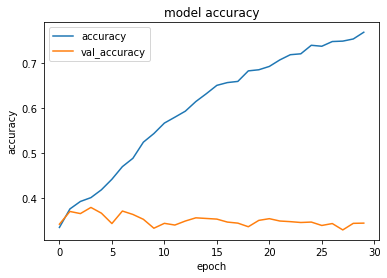

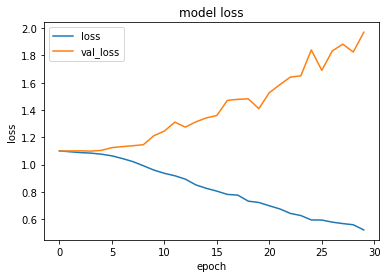

In [72]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [73]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_sw_enc = encode_categ_data(y_test_sw)
for i in y_test_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)   

In [74]:
print(y_pred[0:10])
print(pred_array[0:10])

[[0.31965253 0.6393374  0.04101004]
 [0.29248264 0.6221767  0.08534064]
 [0.24053557 0.6133713  0.14609312]
 [0.17073132 0.5326295  0.2966392 ]
 [0.22212875 0.32920566 0.44866553]
 [0.42120492 0.0966493  0.48214582]
 [0.5515785  0.0658052  0.38261628]
 [0.5653492  0.08176624 0.3528845 ]
 [0.7534113  0.08071183 0.16587684]
 [0.51808995 0.20435087 0.2775592 ]]
[1 1 1 1 2 2 0 0 0 0]


In [75]:
print(y_test_sw_enc[500:510])
print(real_array[500:510])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
[0 0 0 0 0 0 0 0 0 2]


In [76]:
y_pred.shape

(710, 3)

In [77]:
pred_array.shape

(710,)

In [78]:
y_test_sw_enc.shape

(710, 3)

In [79]:
real_array.shape

(710,)

In [80]:
accuracy_score_LSTM = accuracy_score(real_array, pred_array)
print('Accuracy Score - LSTM: ', accuracy_score_LSTM)

Accuracy Score - LSTM:  0.34225352112676055


In [81]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.28      0.19      0.22       227
           1       0.35      0.37      0.36       244
           2       0.36      0.46      0.41       239

    accuracy                           0.34       710
   macro avg       0.33      0.34      0.33       710
weighted avg       0.33      0.34      0.33       710



In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[ 42,  92,  93],
       [ 53,  91, 100],
       [ 55,  74, 110]], dtype=int64)

In [83]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in real_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('real_array.size: ', real_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

real_array.size:  710  | cont_buy:  227  | cont_hold:  244  | cont_sell:  239


In [84]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in pred_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('pred_array.size: ', pred_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

pred_array.size:  710  | cont_buy:  150  | cont_hold:  257  | cont_sell:  303


In [85]:
weightedFScore_LSTM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LSTM

0.50595642668381

<AxesSubplot:>

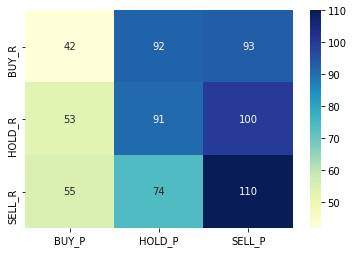

In [86]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LSTM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

In [87]:
y_pred_train_sw = model_lstm.predict(x_train_sw)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train_sw:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score LSTM: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score LSTM: 0.8056


# Resumo

In [88]:
print('-------------Resumo-------------')

print('\nAccuracy Score - LGBM: ', accuracy_score_LGBM)
print('Weighted F Score - LGBM: ', weightedFScore_LGBM)

print('\nAccuracy Score - Random Forest: ', accuracy_score_RF)
print('Weighted F Score - Random Forest: ', weightedFScore_RF)

print('\nAccuracy Score - DNN: ', accuracy_score_DNN)
print('Weighted F Score - DNN: ', weightedFScore_DNN)

print('\nAccuracy Score - LSTM: ', accuracy_score_LSTM)
print('Weighted F Score - LSTM: ', weightedFScore_LSTM)

-------------Resumo-------------

Accuracy Score - LGBM:  0.3651006711409396
Weighted F Score - LGBM:  0.5005989050579096

Accuracy Score - Random Forest:  0.3731543624161074
Weighted F Score - Random Forest:  0.5347305616019927

Accuracy Score - DNN:  0.4
Weighted F Score - DNN:  0.5641741576554308

Accuracy Score - LSTM:  0.34225352112676055
Weighted F Score - LSTM:  0.50595642668381


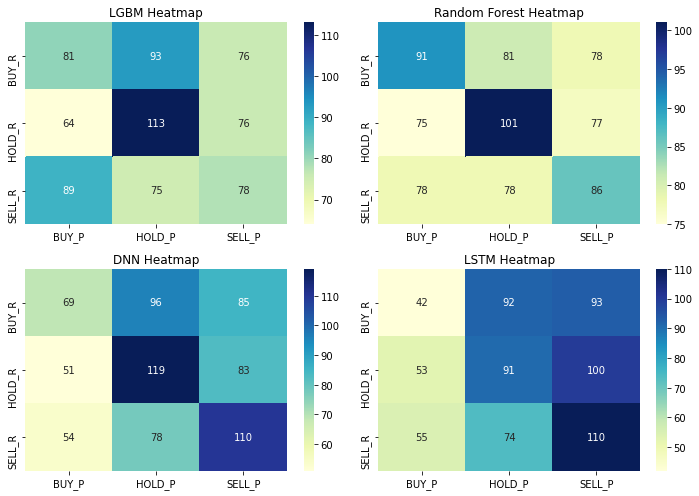

In [99]:
plt.figure(figsize=[10,7])
plt.subplot(2,2,1)
plt.title('LGBM Heatmap')
sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,2)
plt.title('Random Forest Heatmap')
sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,3)
plt.title('DNN Heatmap')
sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,4)
plt.title('LSTM Heatmap')
sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

plt.tight_layout()

In [93]:
# save trained model
#pickle.dump( model_lgbm, open( 'saved_models/model_LGBM_53features_5000.pkl', 'wb' ) )

In [94]:
#pickle.dump( model_dnn, open( 'saved_models/model_DNN_53features_100.pkl', 'wb' ) )

In [95]:
#pickle.dump( model_randomF, open( 'saved_models/model_RF_53features_5000.pkl', 'wb' ) )